In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Activation
import os
import cv2
import numpy as np
import shutil
import random
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer as LabelBinarizer

DEFAULTCWD = os.getcwd() +"/"
print(DEFAULTCWD)
data_folder_path = 'datasets/BoxingYoutubeGuy/'
dirs = os.listdir(data_folder_path)
print(dirs)
print("READY")

Using TensorFlow backend.


D:\BigDataApps\PythonProjects\PROJECT\MMA-Posture\ML/
['guard', 'jab', 'uppercut']
READY


## Grab data & Create labels

In [2]:
data = []
count = 0
labels = []
postureCount = 0
for pose in dirs:
    print(pose)
    fileNames = os.listdir(data_folder_path + pose)
    print(data_folder_path + pose + "/" + str(fileNames))
    for file in fileNames:
        print("Processing: "+file)
        data.append(pd.read_csv(data_folder_path + pose + "/" + file).values)
        for i in range(len(data[count])):
            labels.append(postureCount)
        print(i)
        print(len(data[count]))
        count+=1
    postureCount+=1
#data[0] = pd.read_csv("datasets/jab/dataset_1591367620.csv").values
#data[1] =pd.read_csv("datasets/guard/dataset_1591367620.csv").values
print(len(labels))


guard
datasets/BoxingYoutubeGuy/guard/['dataset1010_1592345309.csv', 'dataset2035_1592346103.csv', 'dataset3000_1592346942.csv']
Processing: dataset1010_1592345309.csv
166
167
Processing: dataset2035_1592346103.csv
124
125
Processing: dataset3000_1592346942.csv
77
78
jab
datasets/BoxingYoutubeGuy/jab/['dataset1010_1592345309.csv', 'dataset2035_1592346103.csv', 'dataset3000_1592346942.csv']
Processing: dataset1010_1592345309.csv
293
294
Processing: dataset2035_1592346103.csv
150
151
Processing: dataset3000_1592346942.csv
87
88
uppercut
datasets/BoxingYoutubeGuy/uppercut/['dataset1010_1592345309.csv', 'dataset2035_1592346103.csv', 'dataset3000_1592346942.csv']
Processing: dataset1010_1592345309.csv
144
145
Processing: dataset2035_1592346103.csv
23
24
Processing: dataset3000_1592346942.csv
207
208
1280


#### Just for checking data types, make sure there is no strings etc

In [3]:
#### CHECKING TYPES
def checkDataTypes(dataset):
    for one in dataset:
        print(type(one))
        for two in one:
            print(type(two))
            for three in two:
                print(type(three))
                for four in three:
                    print(type(four))

## Data Formatting
The data we get is string so we'll need to parse that to float. Besides that, this method also takes care of reshaping

In [4]:

import re
def formatDataset(data):
    dataset = []  
    count = 0
    for pose in data:
        for row in pose:
            dataset.append([]) #Person (useless dimension, but needed to get 4d)
            personCount = 0
            for person in range(1):
                dataset[count].append([]) #Frame (This is the actual keypoint array (aka 1 row in the excel))
                for cell in row: # The cell is a string (aka xyc) so we'll split by comma and format each number we get 
                    if cell == "0":
                        cell = "0,0,0"
                    if type(cell) != float:
                        buffer = cell.split(',')
                        array = np.empty(shape=len(buffer)) # Was necessary due to it being a float or something
                        i = 0
                        for number in buffer:
                            array[i] = float(number)
                            i+=1
                        #print(array)
                        dataset[count][personCount].append(array) # Put it in the main dataset
                personCount += 1
            count += 1
    return np.array(dataset) # Parse it into a numpy array and return! 
                            #(It was a Python array in the beginning) 
                            # Reason why it's like this is due to the 'efficency' of numpy arrays makes them not able to
                            # have data appended to them, the size of the array has to be known. 
                            # But Python array is easier to work with in this case


In [5]:
ds = formatDataset(data) 
# Checking if everything has the correct type
print(type(ds))
print(len(ds))
print(type(ds[0]))
print(len(ds[0]))
print(type(ds[0][0]))
print(len(ds[0][0]))
print(type(ds[0][0][0]))
print(len(ds[0][0][0]))
print(type(ds[0][0][0][0]))

# perform "one-hot" encoding on the labels (Make label into a number but still remember the string related to the number) 
# aka enum



print(len(labels))

#labels = lb.fit_transform(labels)
#print(len(labels))
#labels = labels.flatten()
#print(len(labels))

y = []
for label in labels:
    y.append(label)
y = np.array(y)    
y.reshape(-1)
something = np.eye(len(dirs))[y]
print(something)




<class 'numpy.ndarray'>
1280
<class 'numpy.ndarray'>
1
<class 'numpy.ndarray'>
25
<class 'numpy.ndarray'>
3
<class 'numpy.float64'>
1280
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [6]:
# Check how the dataset looks like and if the ds length vs label lenght is matching
print(len(labels))
print(len(ds))
print(ds)


1280
1280
[[[[266.778    129.61       0.88097 ]
   [243.216    144.051      0.830097]
   [222.282    140.131      0.827732]
   ...
   [198.844    412.859      0.77055 ]
   [189.686    412.843      0.74081 ]
   [180.543    397.195      0.732139]]]


 [[[264.098    128.343      0.858561]
   [238.015    145.339      0.806776]
   [215.821    141.425      0.834867]
   ...
   [198.848    412.853      0.771591]
   [189.69     412.857      0.743157]
   [179.26     399.802      0.730254]]]


 [[[261.486    127.079      0.840471]
   [238.011    142.77       0.843199]
   [214.491    141.448      0.860426]
   ...
   [198.848    412.842      0.776238]
   [189.689    412.842      0.74279 ]
   [179.269    399.762      0.726981]]]


 ...


 [[[351.531    119.214      0.800702]
   [402.397    140.13       0.684126]
   [414.186    145.329      0.53644 ]
   ...
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]]


 [[[350.23     119.27      

In [7]:
# split data into train and test
print(len(something))
print(len(ds))
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(ds, something, test_size=0.25, stratify=labels, random_state=42)

print("SHAPES")
print("ORIGINAL SHAPE: "+ str(ds.shape))
print("TRAIN SINGLE SHAPE: "+ str(trainX[0].shape))
print("TRAIN ARRAY SHAPE: "+str(trainX.shape))
print("TEST SINGLE SHAPE: "+ str(testX[0].shape))
print("TEST ARRAY SHAPE: "+str(testX.shape))

1280
1280
SHAPES
ORIGINAL SHAPE: (1280, 1, 25, 3)
TRAIN SINGLE SHAPE: (1, 25, 3)
TRAIN ARRAY SHAPE: (960, 1, 25, 3)
TEST SINGLE SHAPE: (1, 25, 3)
TEST ARRAY SHAPE: (320, 1, 25, 3)


In [8]:
from tensorflow.keras.regularizers import l2
# CONFIGS
init = "he_normal"
reg = l2(0.0005)
inputShape = (1,25,3)
chanDim = -1
classes = len(dirs) # len of labels (2 for now)
####



model = Sequential()

# This is mostly copied for Kim's link, I only changed the Conv2D things the example: (1,4)
# 16 FILTERS
# 7x7 filters -- 2x2 strides
# the spatial dimensions of the volume
model.add(Conv2D(16, (1, 4), strides=(2, 2), padding="valid",
    kernel_initializer=init, kernel_regularizer=reg,
    input_shape=inputShape))
# here we stack two CONV layers on top of each other where
# each layerswill learn a total of 32 (3x3) filters
model.add(Conv2D(32, (3, 3), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# stack two more CONV layers, keeping the size of each filter

# as 3x3 but increasing to 64 total learned filters
model.add(Conv2D(64, (2, 2), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (2, 6), strides=(2, 2), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# increase the number of filters again, this time to 128
model.add(Conv2D(128, (6, 4), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# fully-connected layer
model.add(Flatten())
model.add(Dense(512, kernel_initializer=init))
model.add(Activation("relu"))
#model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))

print("MODEL PREPARED")


MODEL PREPARED


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
print("MODEL COMPILED")

MODEL COMPILED


In [10]:
history = model.fit(trainX, trainY, batch_size=32,
    validation_data=(testX, testY), epochs=200) # Change to 20 epochs when testing 

print("TRAINING COMPLETE")


Train on 960 samples, validate on 320 samples
Epoch 1/200
960/960 [==============================] - 2s 2ms/step - loss: 6.0941 - accuracy: 0.3469 - val_loss: 1.3856 - val_accuracy: 0.4344
Epoch 2/200
960/960 [==============================] - 1s 697us/step - loss: 1.4295 - accuracy: 0.3865 - val_loss: 1.2605 - val_accuracy: 0.4938
Epoch 3/200
960/960 [==============================] - 1s 750us/step - loss: 1.2934 - accuracy: 0.4021 - val_loss: 1.1848 - val_accuracy: 0.5063
Epoch 4/200
960/960 [==============================] - 1s 745us/step - loss: 1.2632 - accuracy: 0.4302 - val_loss: 1.1554 - val_accuracy: 0.5375
Epoch 5/200
960/960 [==============================] - 1s 713us/step - loss: 1.2252 - accuracy: 0.4354 - val_loss: 1.1320 - val_accuracy: 0.5094
Epoch 6/200
960/960 [==============================] - 1s 847us/step - loss: 1.1791 - accuracy: 0.4792 - val_loss: 1.0788 - val_accuracy: 0.5688
Epoch 7/200
960/960 [==============================] - 1s 1ms/step - loss: 1.1724 - ac

Epoch 57/200
960/960 [==============================] - 1s 1ms/step - loss: 0.6419 - accuracy: 0.7979 - val_loss: 0.6000 - val_accuracy: 0.8188
Epoch 58/200
960/960 [==============================] - 1s 1ms/step - loss: 0.6282 - accuracy: 0.8177 - val_loss: 0.5406 - val_accuracy: 0.8531
Epoch 59/200
960/960 [==============================] - 1s 1ms/step - loss: 0.6103 - accuracy: 0.8094 - val_loss: 0.6003 - val_accuracy: 0.8062
Epoch 60/200
960/960 [==============================] - 1s 1ms/step - loss: 0.6724 - accuracy: 0.7781 - val_loss: 0.5808 - val_accuracy: 0.8500
Epoch 61/200
960/960 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.8102 ETA: 0s - loss: 0.6638 -  - 1s 962us/step - loss: 0.5997 - accuracy: 0.8177 - val_loss: 0.5513 - val_accuracy: 0.8406
Epoch 62/200
960/960 [==============================] - 1s 843us/step - loss: 0.5815 - accuracy: 0.8271 - val_loss: 0.5158 - val_accuracy: 0.8719
Epoch 63/200
960/960 [==============================] - 1s 931

Epoch 113/200
960/960 [==============================] - 1s 1ms/step - loss: 0.4131 - accuracy: 0.8927 - val_loss: 0.4738 - val_accuracy: 0.8531
Epoch 114/200
960/960 [==============================] - 1s 1ms/step - loss: 0.4465 - accuracy: 0.8792 - val_loss: 0.4518 - val_accuracy: 0.8875
Epoch 115/200
960/960 [==============================] - 1s 920us/step - loss: 0.4134 - accuracy: 0.8917 - val_loss: 0.4823 - val_accuracy: 0.8719
Epoch 116/200
960/960 [==============================] - 1s 954us/step - loss: 0.4307 - accuracy: 0.8854 - val_loss: 0.5048 - val_accuracy: 0.8469
Epoch 117/200
960/960 [==============================] - 1s 886us/step - loss: 0.4797 - accuracy: 0.8458 - val_loss: 0.4681 - val_accuracy: 0.8906
Epoch 118/200
960/960 [==============================] - 1s 1ms/step - loss: 0.3981 - accuracy: 0.8969 - val_loss: 0.4416 - val_accuracy: 0.8750
Epoch 119/200
960/960 [==============================] - 1s 1ms/step - loss: 0.3842 - accuracy: 0.8906 - val_loss: 0.4689 - 

Epoch 169/200
960/960 [==============================] - 1s 935us/step - loss: 0.3215 - accuracy: 0.9094 - val_loss: 0.5107 - val_accuracy: 0.8594
Epoch 170/200
960/960 [==============================] - 1s 1ms/step - loss: 0.3729 - accuracy: 0.8927 - val_loss: 0.4031 - val_accuracy: 0.8969
Epoch 171/200
960/960 [==============================] - 1s 1ms/step - loss: 0.3189 - accuracy: 0.9135 - val_loss: 0.4324 - val_accuracy: 0.8813
Epoch 172/200
960/960 [==============================] - 1s 1ms/step - loss: 0.3113 - accuracy: 0.9177 - val_loss: 0.3746 - val_accuracy: 0.9125
Epoch 173/200
960/960 [==============================] - 2s 2ms/step - loss: 0.3723 - accuracy: 0.9021 - val_loss: 0.3751 - val_accuracy: 0.9062
Epoch 174/200
960/960 [==============================] - 2s 2ms/step - loss: 0.3536 - accuracy: 0.9073 - val_loss: 0.4128 - val_accuracy: 0.9094
Epoch 175/200
960/960 [==============================] - 2s 2ms/step - loss: 0.3068 - accuracy: 0.9271 - val_loss: 0.4140 - val_

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 11, 16)         208       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 11, 32)         4640      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 11, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 6, 32)          9248      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 6, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 6, 64)         

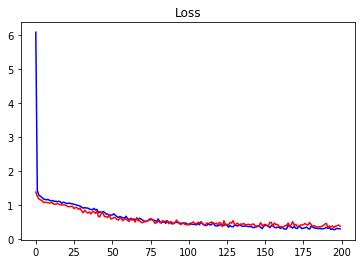

In [12]:
plt.subplot(111)
plt.title('Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='train')


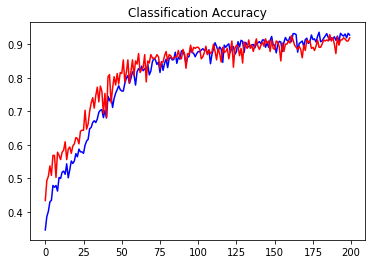

In [13]:
plt.subplot(111)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='train')

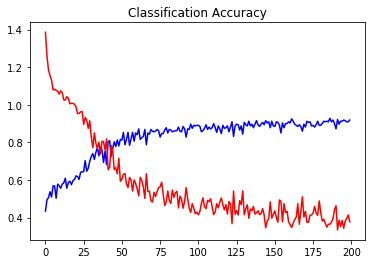

In [14]:
plt.subplot(111)
plt.title('Classification Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='train') # UP IS GOOD
plt.plot(history.history['val_loss'], color='red', label='train') # DOWN IS GOOD
# UP UP IS BAD = OVERFITTING
# acc DOWN loss UP IS BAD = NOT LEARNING 

In [15]:
from sklearn.metrics import classification_report
lb = LabelBinarizer()

print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=dirs))

[INFO] evaluating network...
              precision    recall  f1-score   support

       guard       0.85      0.98      0.91        93
         jab       0.93      0.92      0.92       133
    uppercut       0.99      0.86      0.92        94

    accuracy                           0.92       320
   macro avg       0.92      0.92      0.92       320
weighted avg       0.92      0.92      0.92       320



In [16]:
model.save(DEFAULTCWD + 'final_model_boxing.h5')

## Predicting

In [17]:
from keras.models import load_model
from decimal import Decimal

# load model
loadedModel = load_model('final_model_boxing.h5')
jab1 = np.array([[[[1236.63,303.692,0.834197],[1336.76,362.516,0.638253],[1286.77,389.049,0.566805],[1257.21,503.696,0.553584],[1213.26,389.018,0.599918],[1383.79,339.01,0.630664],[1263.21,338.885,0.581837],[1186.64,338.905,0.417541],[1345.51,656.879,0.531741],[1304.42,656.827,0.529901],[1280.91,880.518,0.737282],[1286.68,1074.88,0.373105],[1378.03,662.695,0.511506],[1375.01,909.993,0.790882],[0,0,0],[0,0,0],[1242.59,288.834,0.838842],[0,0,0],[1304.23,274.237,0.842388],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[1292.56,1074.9,0.159261]]]])
guard = np.array([[[[1242.5,288.903,0.842958],[1351.52,362.463,0.827891],[1301.41,365.414,0.659089],[1289.64,483.129,0.375675],[1251.41,412.637,0.489724],[1410.35,359.481,0.707714],[1374.97,503.847,0.865088],[1280.92,385.915,0.824042],[1336.78,668.605,0.584321],[1289.62,665.661,0.569115],[1280.77,886.473,0.701639],[1292.59,1074.89,0.199699],[1386.77,671.525,0.543603],[1398.47,912.955,0.738666],[0,0,0],[1239.68,268.418,0.117724],[1257.25,268.2,0.916847],[0,0,0],[1316.11,262.419,0.833294],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[1304.22,1074.91,0.0680288]]]])
zero = np.array([[[[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]]]])
jab2 = np.array([[[[954.111,271.155,0.962893],[1021.87,365.389,0.869893],[930.657,362.538,0.725718],[821.642,386.018,0.845439],[762.802,327.208,0.781711],[1110.11,365.464,0.795738],[1163.16,480.166,0.898922],[1051.29,365.496,0.799284],[1018.8,671.504,0.594384],[954.003,671.515,0.593353],[948.112,889.402,0.644103],[948.165,1074.87,0.435388],[1077.75,671.561,0.563232],[1092.56,889.4,0.749573],[1104.22,1074.9,0.0502091],[951.099,250.696,0.896254],[977.516,250.678,0.954135],[0,0,0],[1024.89,262.5,0.866688],[0,0,0],[0,0,0],[0,0,0],[927.597,1074.86,0.129198],[0,0,0],[951.194,1074.89,0.203952]]]])
results = loadedModel.predict(testX)

labels = np.argmax(results, axis = 1)
counter = [0,0,0]
totalCounter = [0,0,0]

for desiredlbl in range(len(dirs)):
    count = 0
    for result in results:
        if labels[count] == desiredlbl:
            print(str(labels[count]) +" "+ str(round(Decimal(result[labels[count]]*100),2)))
        count += 1
    
count = 0
for result in results:
    if 70 < round(Decimal(result[labels[count]]*100),2):
        counter[labels[count]] += 1
        
    totalCounter[labels[count]] += 1
    count += 1
    

    # 1 == Jab, 0 == Guard



0 99.97
0 99.75
0 99.94
0 92.06
0 99.78
0 99.95
0 99.80
0 98.03
0 94.79
0 99.54
0 99.80
0 100.00
0 91.17
0 99.91
0 91.98
0 96.96
0 97.02
0 91.52
0 100.00
0 99.54
0 99.62
0 91.91
0 92.94
0 99.98
0 98.43
0 93.09
0 99.98
0 74.67
0 99.50
0 82.37
0 90.79
0 99.97
0 92.02
0 84.20
0 97.62
0 99.13
0 99.94
0 91.74
0 99.81
0 99.06
0 90.33
0 99.79
0 98.88
0 99.96
0 99.07
0 91.92
0 99.39
0 99.94
0 96.34
0 74.40
0 99.07
0 97.13
0 92.81
0 88.74
0 96.99
0 94.91
0 88.13
0 99.30
0 99.77
0 100.00
0 99.98
0 99.44
0 99.16
0 99.97
0 97.11
0 94.86
0 100.00
0 99.99
0 99.80
0 96.10
0 99.89
0 96.30
0 96.46
0 99.97
0 99.92
0 99.54
0 78.34
0 99.36
0 83.73
0 92.88
0 52.02
0 90.72
0 99.94
0 99.61
0 99.88
0 100.00
0 90.72
0 99.87
0 99.03
0 99.85
0 97.83
0 70.76
0 99.80
0 99.94
0 99.99
0 99.59
0 99.75
0 99.64
0 51.23
0 98.06
0 99.79
0 81.64
0 97.82
0 57.19
0 94.68
0 99.98
0 49.44
1 99.55
1 70.77
1 99.46
1 100.00
1 99.89
1 98.81
1 87.07
1 99.87
1 99.96
1 99.99
1 97.91
1 99.75
1 100.00
1 99.97
1 79.26
1 96.51
1 88.67
1

In [18]:
print("Guard got "+str(counter[0])+'/'+str(totalCounter[0]))
print("Jab got "+str(counter[1])+'/'+str(totalCounter[1]))
print("Uppercut got "+str(counter[2])+'/'+str(totalCounter[2]))
print("Total: "+str(count))


Guard got 103/107
Jab got 125/131
Uppercut got 75/82
Total: 320


In [19]:
from sklearn.metrics import confusion_matrix as confusion_matrix
confusion_matrix(testY.argmax(axis=1), results.argmax(axis=1))

array([[ 91,   1,   1],
       [ 11, 122,   0],
       [  5,   8,  81]], dtype=int64)